In [2]:
#generamos el import de warnings para evitar avisos de deprecación
import warnings
warnings.filterwarnings('ignore')

#importamos las librerías clásicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#importamos funciones externas de nuestro archivo auxiliar
import lec6_graphs as gfx

#importamos statsmodels para generar modelos de regresión
import statsmodels.api as sm
import statsmodels.formula.api as smf

#definimos parámetros de los gráficos
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (10,6)

In [3]:
#importamos el archivo wells.csv
df = pd.read_csv('wells.csv').drop('index',axis=1)

In [4]:
df.shape

(3020, 5)

In [5]:
df.columns

Index(['y', 'dist100', 'arsenic', 'educ4', 'assoc'], dtype='object')

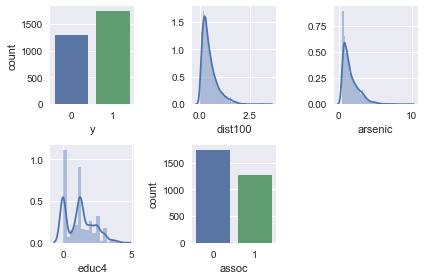

In [6]:
for i, v in enumerate(df):
    plt.subplot(2,3,i+1)
    if len(df[v].value_counts())>2:
        sns.distplot((df[v]))
    else:
        sns.countplot(df[v])
    plt.tight_layout()

In [7]:
sns.heatmap(df.corr(), cmap='Blues', annot=True);

Ya que las variables no son lo suficientemente normales, no necesariamente pueden relacionarse por el método de Pearson por lo que no se distribuyen de forma lineal

In [8]:
m1_ols = smf.ols('y ~ dist100', df).fit()

In [9]:
gfx.concise_summary(m1_ols)



Goodness of Fit statistics
             Statistics      Value
2                 BIC:  4288.4686
3      Log-Likelihood:    -2136.2
4         F-statistic:      42.57
5  Prob (F-statistic):   7.95e-11
6               Scale:    0.24111


Point estimates

               Coef.  Std.Err.
Intercept  0.648407  0.014347
dist100   -0.151539  0.023225


In [10]:
#Intercept: Cuando dist100 vale 0, Intercept vale 0.65, esto quiere decir que si una familia está a 0 metros de un pozo,
#tiene una probabilidad de 65% de cambiarse.
#Para obtener el Puntaje Z, se divide el parámetro estimado por el error estandar
0.648407 / 0.014347

45.19460514393253

In [11]:
# Si se considera un nivel de significancia del 95% el puntaje de corte equivale a 1.96, ya que 45 es mayor, 
# se rechaza la hipotesis nula, por lo que el parámetro se considera sistemático.
# La distancia entre dos individuos que difieren en 100 de un pozo seguro, esto conyeva en una disminución (signo)
# del 15% de probabildiad de cambiarse de pozo 
# Para comprobar esto se mide el nivel de significancia
-0.151539 / 0.023225

-6.5248223896663085

In [12]:
# También se rechaza la hipotesis nula, por lo que podemos decir que tmbn tiene significancia (al 95%)

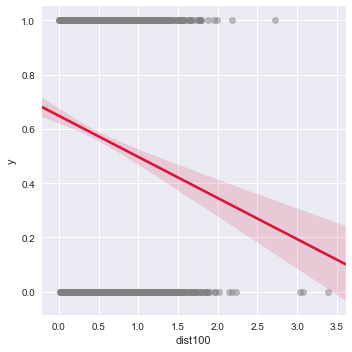

In [13]:
sns.lmplot('dist100','y',df,
          line_kws = {'color':'crimson'},
          scatter_kws= {'color':'grey','alpha':.5})

In [14]:
m1_logit = smf.logit('y ~ dist100', df).fit()
gfx.concise_summary(m1_logit)

Optimization terminated successfully.
         Current function value: 0.674874
         Iterations 4


Goodness of Fit statistics
         Statistics       Value
2             BIC:   4092.2639
3  Log-Likelihood:     -2038.1
4         LL-Null:     -2059.0
5     LLR p-value:  9.7978e-11
6           Scale:      1.0000
7                             


Point estimates

               Coef.  Std.Err.
Intercept  0.605959  0.060310
dist100   -0.621882  0.097426


In [15]:
dist100_mean = df['dist100'].mean()
estimate_y = m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * dist100_mean)
print(estimate_y)

0.30539223925157555


In [16]:
def invlogit(x):
    return 1 / (1 + np.exp(-x))

print(invlogit(estimate_y))

0.5757601624040816


In [17]:
dist100_mean

0.48331862570424283

In [18]:
# La probabilidad promedio de cambiarse de pozo cuando la distancia promedio es de 48 metros es de 58%

In [19]:
pr_dist_100 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 1))
pr_dist_200 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 2))
pr_dist_300 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 3))
pr_dist_400 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 4))

In [20]:
print('La probabilidad de cambiar entre 100 y 200 es', round(pr_dist_100 - pr_dist_200, 3))
print('La probabilidad de cambiar entre 200 y 300 es', round(pr_dist_200 - pr_dist_300, 3))
print('La probabilidad de cambiar entre 300 y 400 es', round(pr_dist_300 - pr_dist_400, 3))

La probabilidad de cambiar entre 100 y 200 es 0.15
La probabilidad de cambiar entre 200 y 300 es 0.125
La probabilidad de cambiar entre 300 y 400 es 0.089


In [21]:
decision_boundary = - m1_logit.params['Intercept'] / m1_logit.params['dist100']
decision_boundary

0.9743961500705298

In [22]:
# Cuando una familia se posicione a 97 metros de un pozo este va a tener una probabilidad equidistante de .5

(0.0, 0.8)

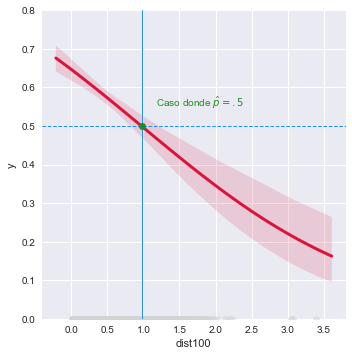

In [23]:
sns.lmplot('dist100', 'y', df, logistic=True, 
          line_kws={'color':'crimson','lw':3},
          scatter_kws={'color':'lightgrey', 'alpha':.5})
plt.axvline(decision_boundary, lw=1, color='dodgerblue')
plt.axhline(.5, linestyle='--', color='dodgerblue', lw=1)
plt.text(decision_boundary + .2, .55, r'Caso donde $\hat{p}=.5$',color='forestgreen')
plt.plot(decision_boundary, .5, 'o', color='forestgreen')
plt.ylim(0.0, 0.8)

In [24]:
# Este pundo indica donde la probabildiad cambiarse de pozo (izq) o no camibarse de pozo (der) son iguales

In [25]:
print("\nOLS - LPM")
gfx.concise_summary(m1_ols, print_fit=False)
print("\nLogic")
gfx.concise_summary(m1_logit, print_fit=False)


OLS - LPM


Point estimates

               Coef.  Std.Err.
Intercept  0.648407  0.014347
dist100   -0.151539  0.023225

Logic


Point estimates

               Coef.  Std.Err.
Intercept  0.605959  0.060310
dist100   -0.621882  0.097426


In [26]:
-0.621882 / 4

-0.1554705

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'dist100':'assoc'],
                                                   df['y'],
                                                   test_size=.33,
                                                   random_state=11238)

In [28]:
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

/Users/hugopriest/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/hugopriest/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/hugopriest/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/hugopriest/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [29]:
default_model = LogisticRegression().fit(X_train_std, y_train)

In [30]:
default_model.coef_

array([[-0.33263063,  0.59061437,  0.14254114, -0.05194878]])

In [31]:
default_model.intercept_

array([0.34129115])

In [32]:
yhat = default_model.predict(X_test_std)
yhat[:20]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1])

In [33]:
type(X_test_std)

numpy.ndarray

In [34]:
yhat_pr = default_model.predict_proba(X_test_std)
yhat_pr[:20]

array([[0.66929521, 0.33070479],
       [0.33241721, 0.66758279],
       [0.09050567, 0.90949433],
       [0.69663803, 0.30336197],
       [0.40191418, 0.59808582],
       [0.45420695, 0.54579305],
       [0.30795975, 0.69204025],
       [0.34931325, 0.65068675],
       [0.4542986 , 0.5457014 ],
       [0.4672401 , 0.5327599 ],
       [0.44980554, 0.55019446],
       [0.4101141 , 0.5898859 ],
       [0.21500112, 0.78499888],
       [0.60289983, 0.39710017],
       [0.56806581, 0.43193419],
       [0.57897805, 0.42102195],
       [0.53655242, 0.46344758],
       [0.43437352, 0.56562648],
       [0.39986145, 0.60013855],
       [0.40614382, 0.59385618]])

In [35]:
from sklearn.metrics import confusion_matrix

m1_confusion = confusion_matrix(y_test, yhat)
m1_confusion

array([[171, 251],
       [117, 458]])

In [36]:
# La diagonal (0,0 y 1,1) reportan los casos exitosamente predichos

In [37]:
from sklearn.metrics import accuracy_score
m1_acc = accuracy_score(y_test, yhat)
m1_acc

0.6308926780341023

In [38]:
# Tiene una exactitud del 63%. Dado que el clasificador aleatorio tiene una exactitud de 50%, se debe comparar con este

In [39]:
m1_acc - .5

0.13089267803410232

In [40]:
# El modelo tiene un desempeño del 13% superior que un clasificador aleatorio

In [41]:
from sklearn.metrics import precision_score
m1_prec = precision_score(y_test, yhat)
m1_prec

0.6459802538787024

In [42]:
from sklearn.metrics import recall_score
m1_recall = recall_score(y_test, yhat)
m1_recall

0.7965217391304348

In [43]:
from sklearn.metrics import f1_score
m1_fscore = f1_score(y_test, yhat)
m1_fscore

0.7133956386292836

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.59      0.41      0.48       422
           1       0.65      0.80      0.71       575

   micro avg       0.63      0.63      0.63       997
   macro avg       0.62      0.60      0.60       997
weighted avg       0.62      0.63      0.62       997



In [45]:
from sklearn.metrics import roc_curve
yhat_pr = default_model.predict_proba(X_test)[:,1]

false_positive, true_positive, threshold = roc_curve(y_test, yhat_pr)

Text(0.5, 0, 'Falsos Positivos')

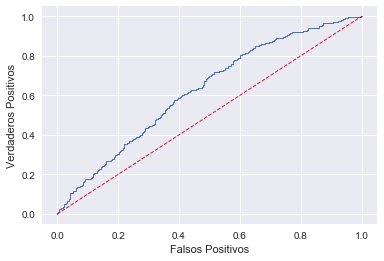

In [46]:
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0,1], linestyle='--', lw=1, color='crimson')
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos')

In [47]:
# Área bajo la curva indica el desempeño del modelo
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, yhat_pr)

0.6267010096847311

In [48]:
# Esto indica que el modelo tiene un desempeño de un 12% mayor al clasificador aleatorio

In [49]:
from sklearn.model_selection import cross_val_score

m1_cv = cross_val_score(LogisticRegression(),
                       X=df.loc[:,'dist100':'assoc'],
                       y=df['y'],
                       cv=3,
                       scoring='f1')

In [50]:
m1_cv

array([0.70499244, 0.68932806, 0.69954476])

In [51]:
# El modelo se mantiene relativamente estable en .7
np.mean(m1_cv)

0.6979550879132436

In [52]:
# Además tiene una desviación estandar baja
np.std(m1_cv)

0.006492993434034528

In [53]:
# Aprox. tiene un 8% más de desempeño que el modelo normal F1

In [54]:
from sklearn.model_selection import LeaveOneOut

m1_cv_loo = cross_val_score(LogisticRegression(),
                       X=df.loc[:,'dist100':'assoc'],
                       y=df['y'],
                       cv=LeaveOneOut(),
                       scoring='accuracy')

In [55]:
m1_cv_loo

array([1., 0., 0., ..., 0., 0., 1.])

In [56]:
np.mean(m1_cv_loo)

0.6139072847682119

In [57]:
np.std(m1_cv_loo)

0.4868522676097273

In [58]:
# Alta insertidumbre en este parámetro dado que la desviación estándar es alta

## Experimento: Evaluación de la complejidad del modelo condicional a términos polinomiales

* __Objetivo:__ Desarrollar una serie de modelos aumentando las interacciones entre variables y evaluar cuál es el mejor modelo.
* __Método:__ Evaluar las métricas F1, Accuracy, Presicion, y Recall entre grados polinomiales (1, 2 y 3). Para cada métrica:

    - Calcula los puntajes de validación cruzada con `k=10` para cada modelo candidato.
    - Genera un objeto DataFrame para guardar las métricas de forma larga mediante .unstack().
    - Por cada objeto DataFrame, graficamos el diagrama de caja.
    - Finiquitamos con detalles estéticos de presentación.